<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC_410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰 센서 데이터로 분류

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/hwa-kim/opt/anaconda3/lib/pytho

In [2]:
!curl -L https://bit.ly/36LsyVs -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   153  100   153    0     0    467      0 --:--:-- --:--:-- --:--:--   467
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    399      0 --:--:--  0:00:02 --:--:--  1782
100 10.5M  100 10.5M    0     0  1862k      0  0:00:05  0:00:03  0:00:02 8316k    0     0  2579k      0  0:00:04  0:00:04 --:--:-- 8820k


In [84]:
!unzip -o smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
  inflating: __MACOSX/._smartphone_human.txt  


In [85]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [86]:
!head -5 smartphone_human.txt

In [87]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)
df.dropna(axis=0, how='any', inplace=True)

In [88]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


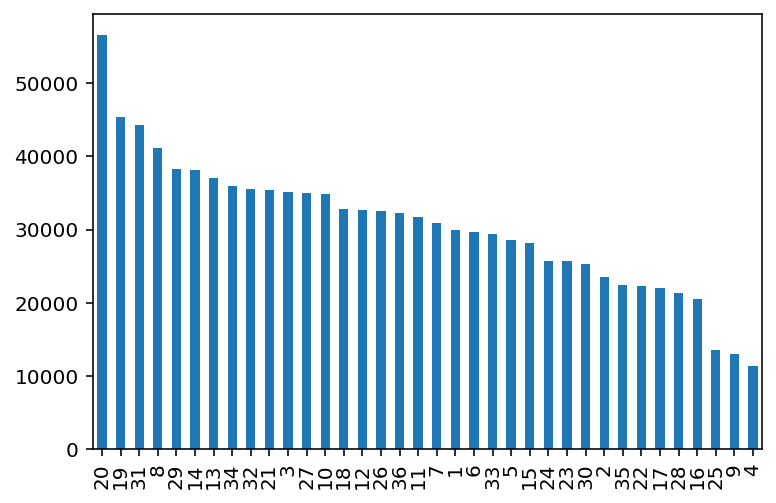

In [89]:
df['user-id'].value_counts().plot(kind='bar')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [90]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

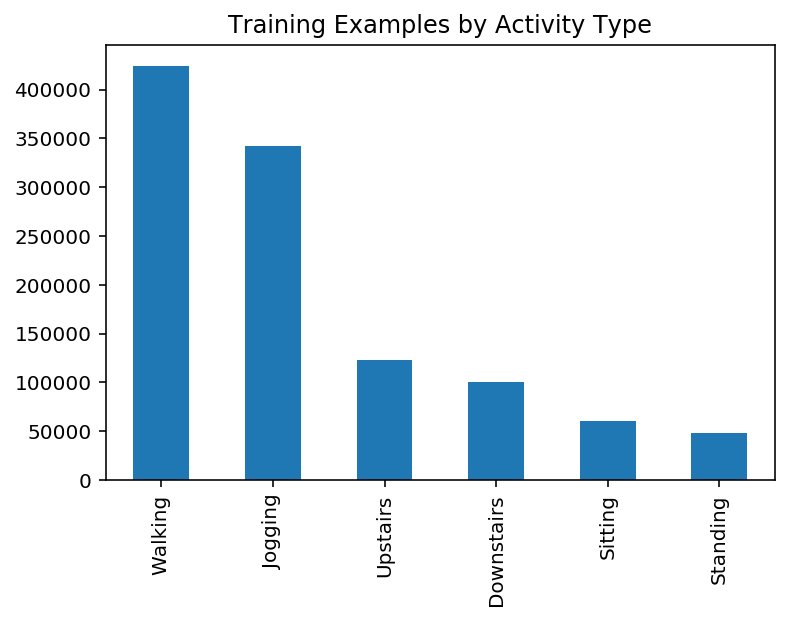

In [91]:
# plt.figure(dpi=200)
df['activity'].value_counts().plot(kind='bar',
    title='Training Examples by Activity Type')
plt.show()

In [92]:
(df['timestamp'] == 0).sum()

12843

In [93]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

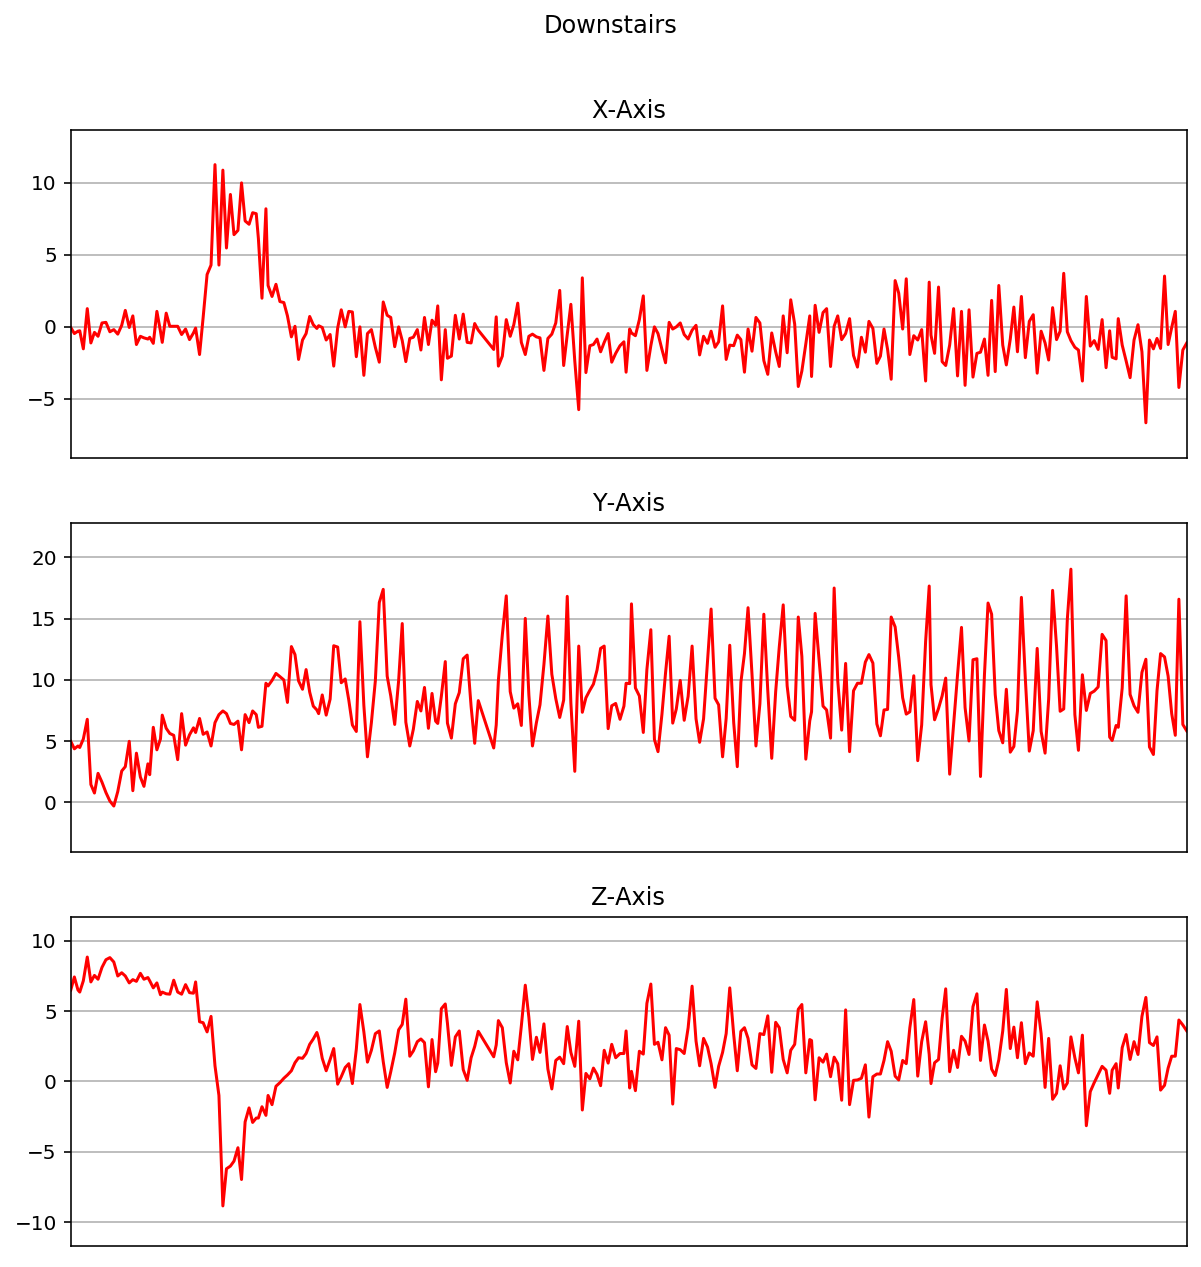

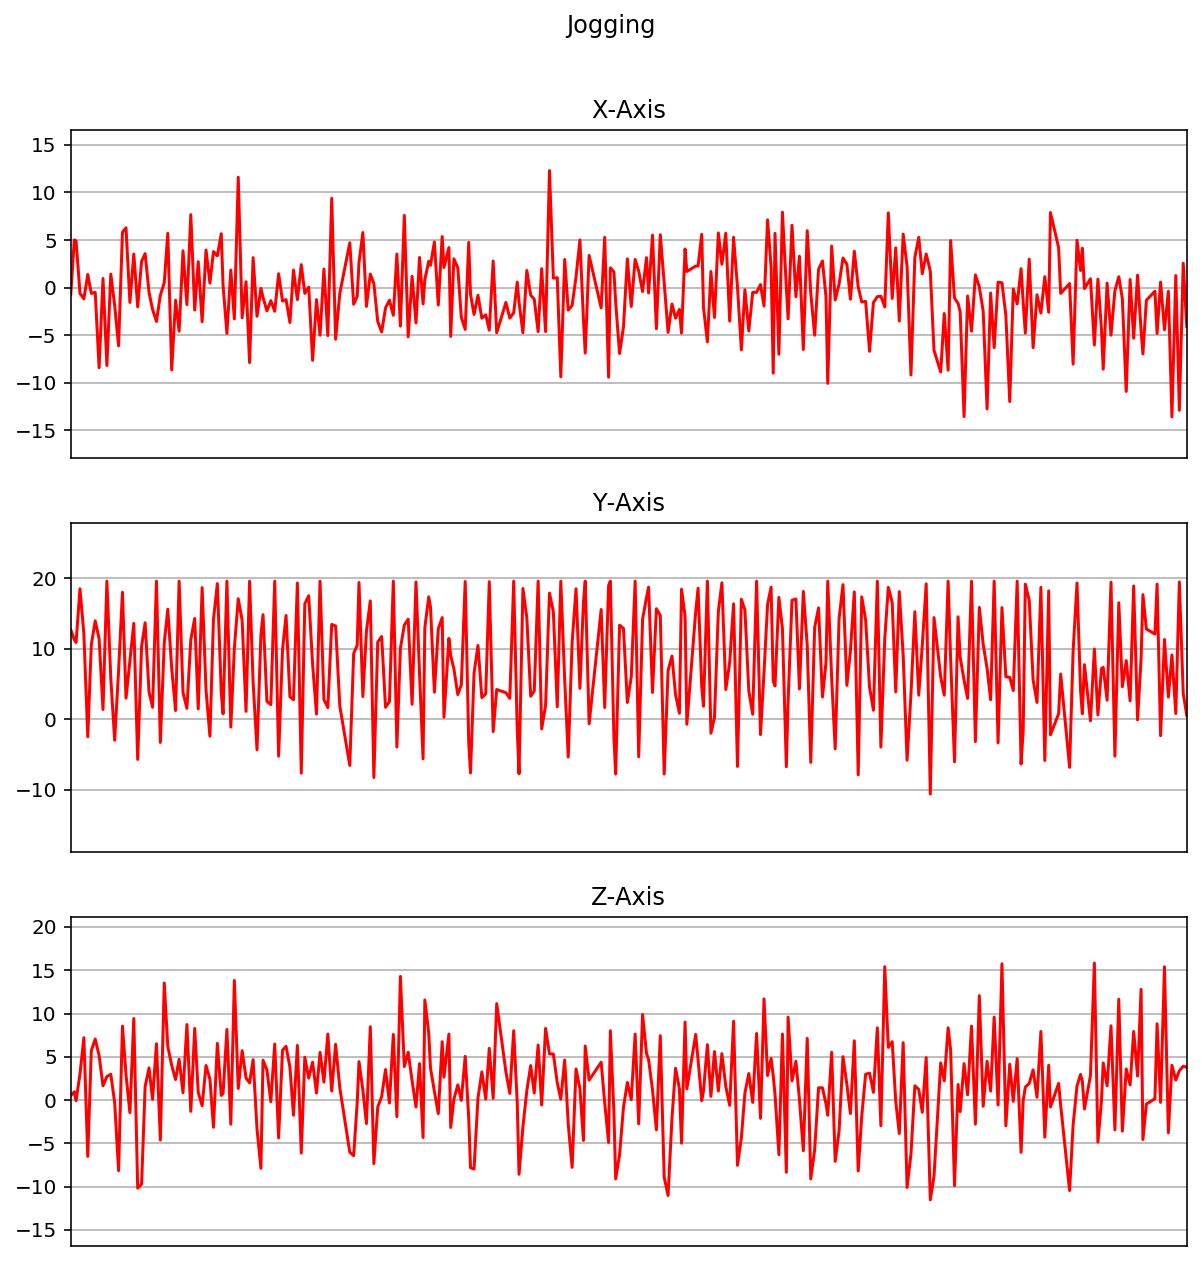

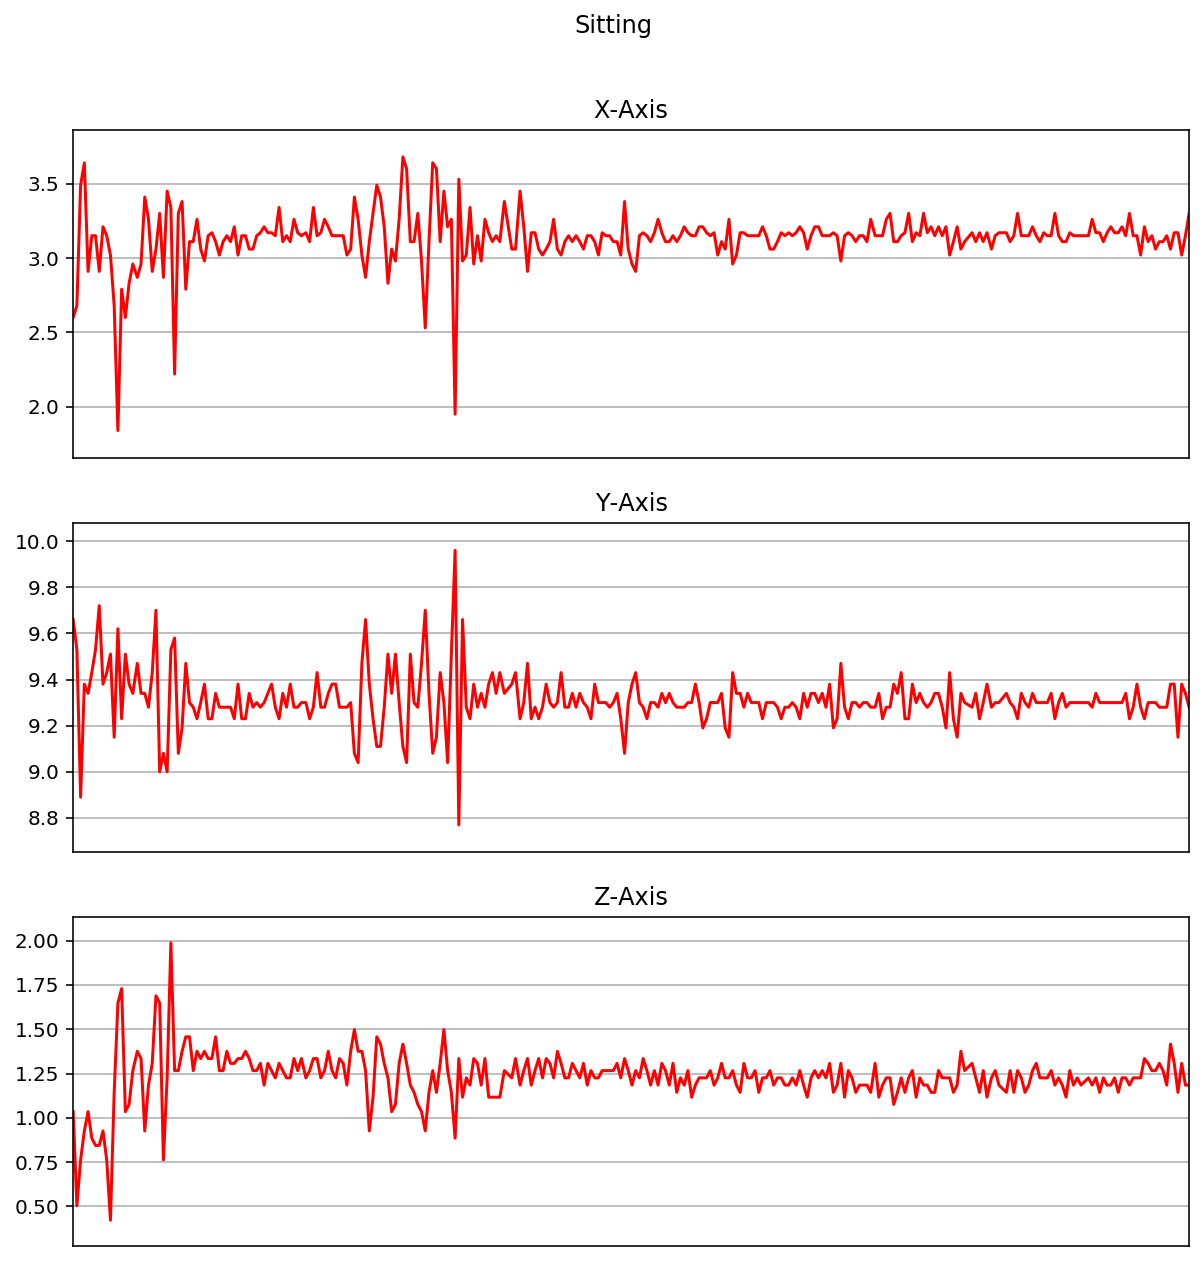

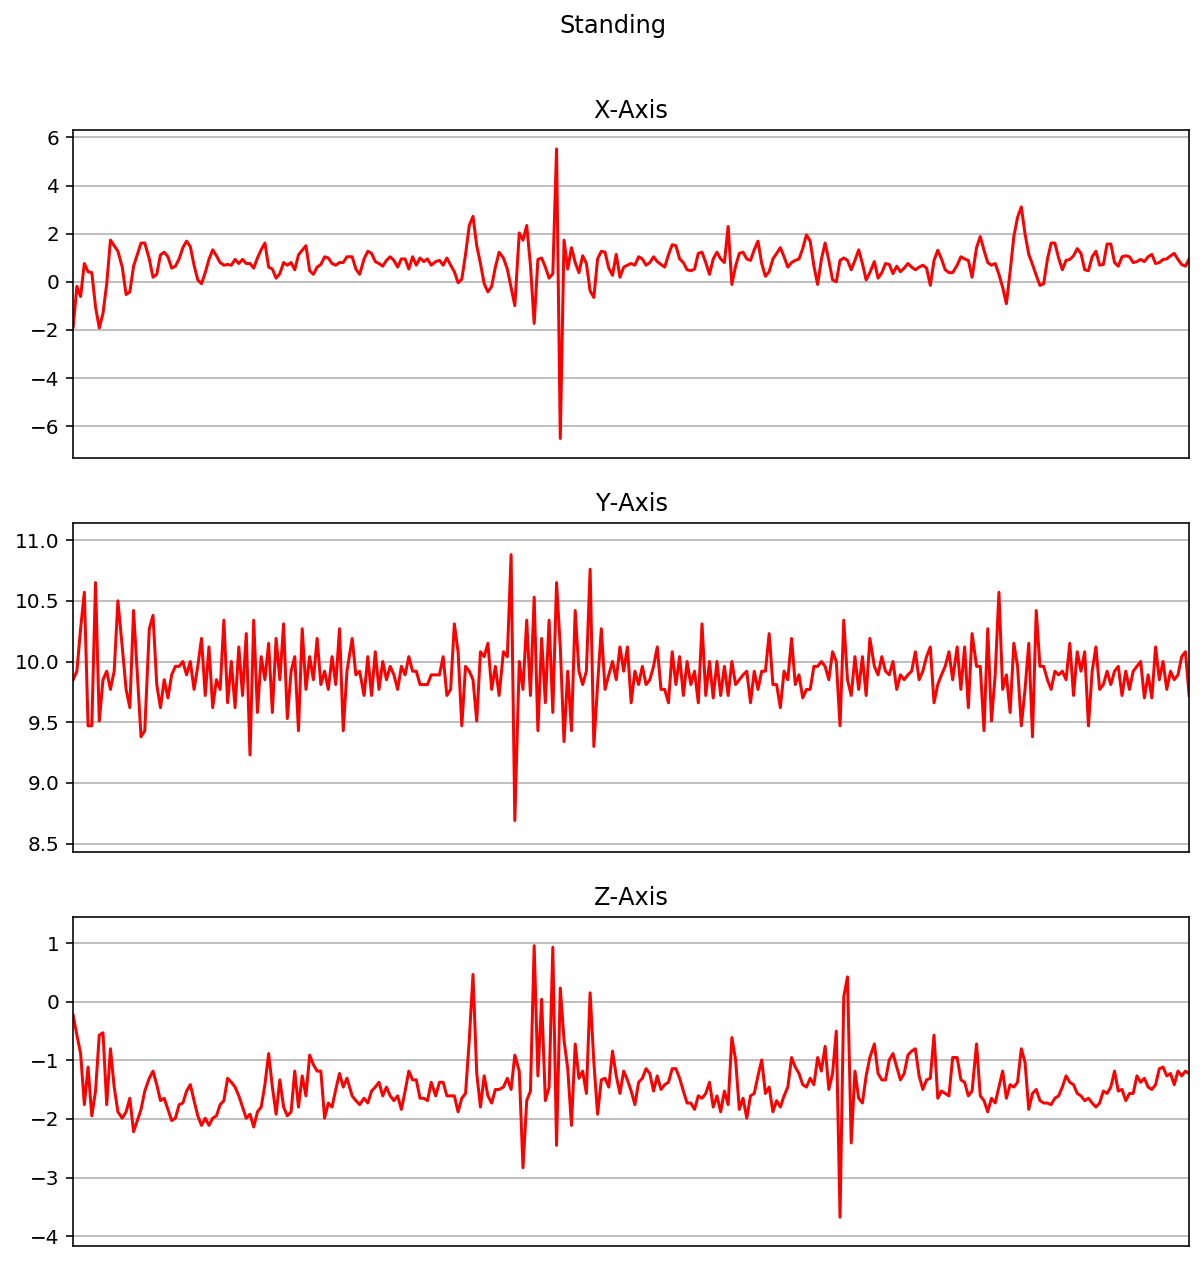

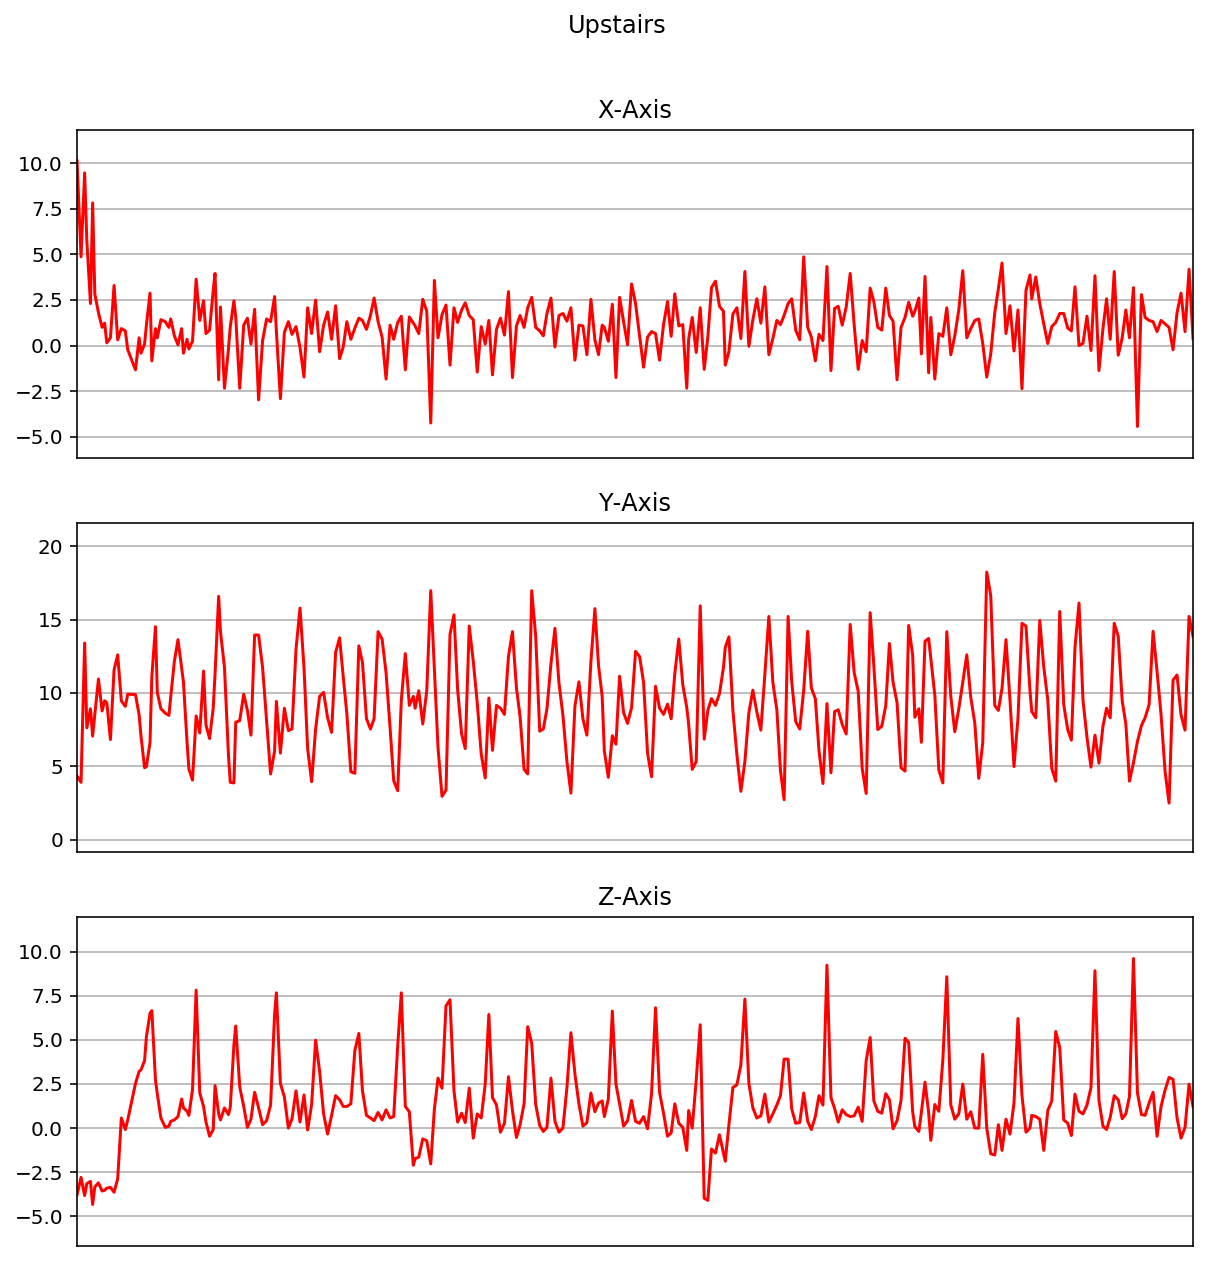

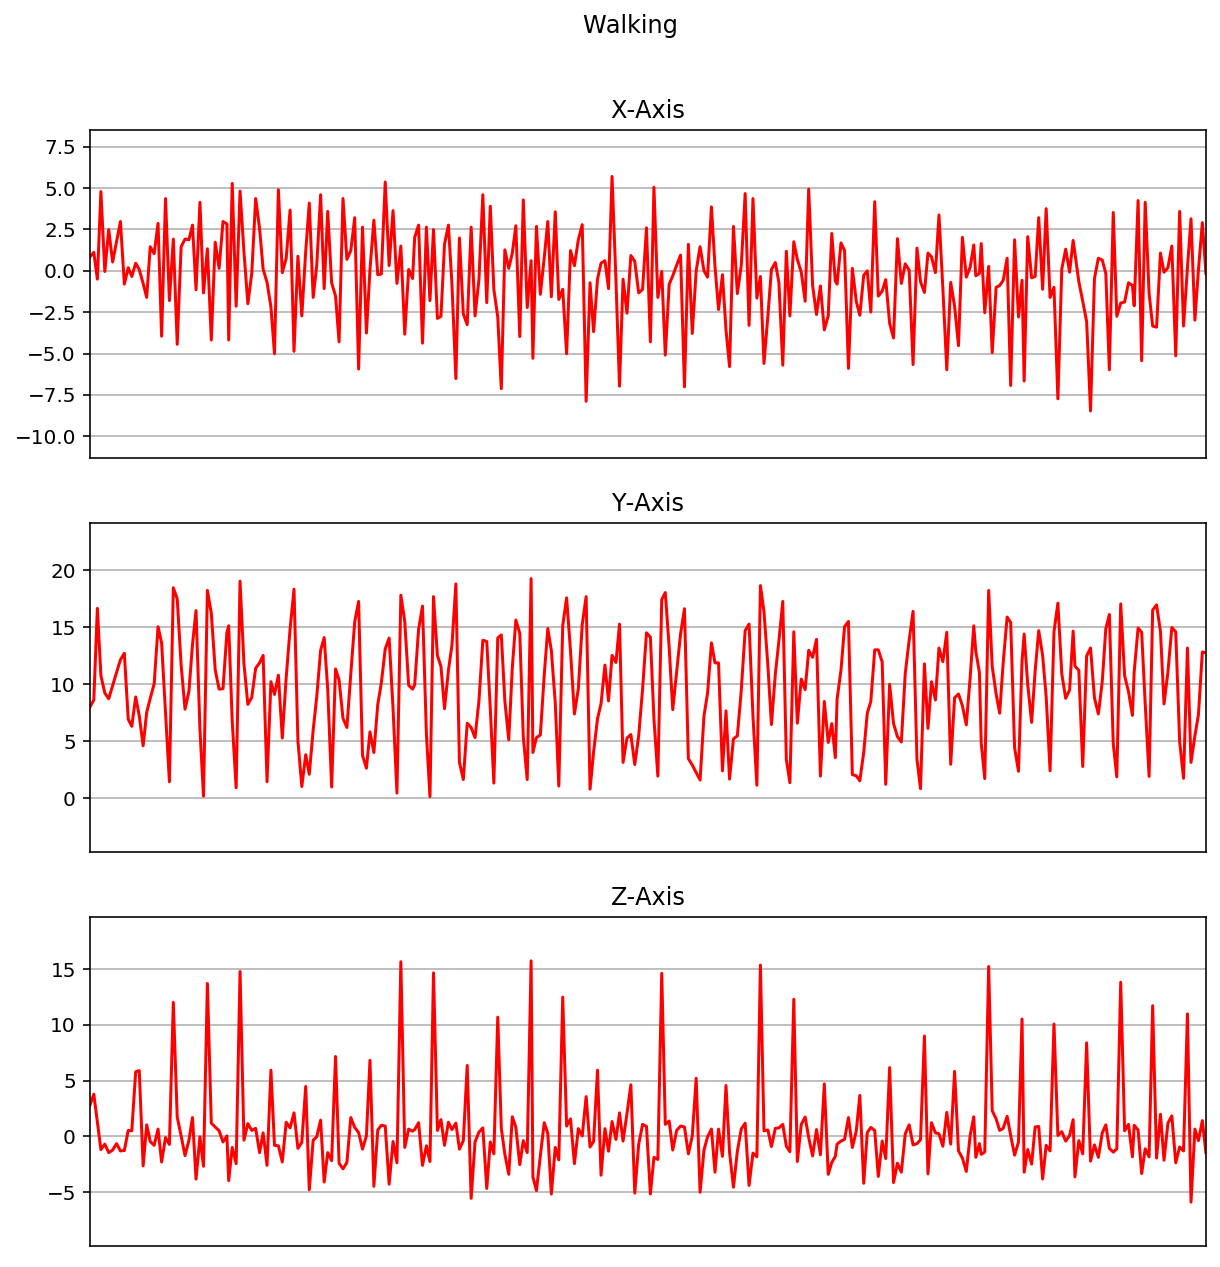

In [29]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [94]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [95]:
le.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [96]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [37]:
test = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4]
m = stats.mode(test)
m

ModeResult(mode=array([3]), count=array([15]))

In [41]:
m[0][0], m[1][0]

(3, 15)

In [44]:
z = stats.mode(df['act'][10000:10100]) # 5초간 관찰
z[0][0], z[1][0]

(5, 100)

In [45]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [97]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [98]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


In [131]:
(df['user-id'] < 28).mean()

0.7410978845728606

In [132]:
(df['user-id'] >= 28).mean()

0.25890211542713937

In [99]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]

In [100]:
def get_xy(N, df):
#     N = 100
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append([xs, ys, zs])
            y.append(action)
    return np.transpose(X, (0,2,1)), np.array(y)

In [101]:
X_train, y_train = get_xy(100, df_train)

In [102]:
X_test, y_test = get_xy(100, df_test)

In [105]:
X_train.shape, X_test.shape

((7752, 100, 3), (2713, 100, 3))

In [118]:
y_train.shape, y_test.shape

((7752, 6), (2713, 6))

In [52]:
# # N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
# N = 100
# X, y = [], []
# for i in range(0, len(df)-N+1, N):
#     z = stats.mode(df['act'][i: i+N])
#     action, count = z[0][0], z[1][0]
#     if count == N:
#         xs = df['x-axis'].values[i: i + N]
#         ys = df['y-axis'].values[i: i + N]
#         zs = df['z-axis'].values[i: i + N]
#         X.append([xs, ys, zs])
#         y.append(action)
# X = np.transpose(X, (0,2,1))
# y = np.array(y)

In [76]:
X2 = X[:1000,:,0:1]
X2.shape

(1000, 100, 1)

In [53]:
X.shape

(10469, 100, 3)

In [106]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## 랜덤 포레스트

In [55]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [119]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)

rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.6336159233321047

# MLP

In [121]:
y.shape

(10469, 6)

In [127]:
model_m = Sequential()
# model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(100, activation='relu',input_shape=(N*3,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [128]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

h = model_m.fit(X_train,
                      y_train,
                      batch_size=10,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/Keras-2.3.1-py3.7.egg/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


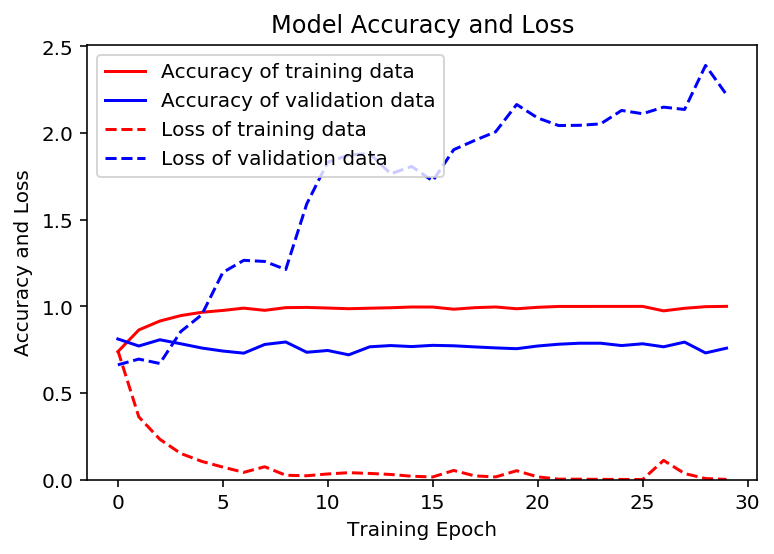

In [124]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    
show_4_graphs(h)

In [125]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

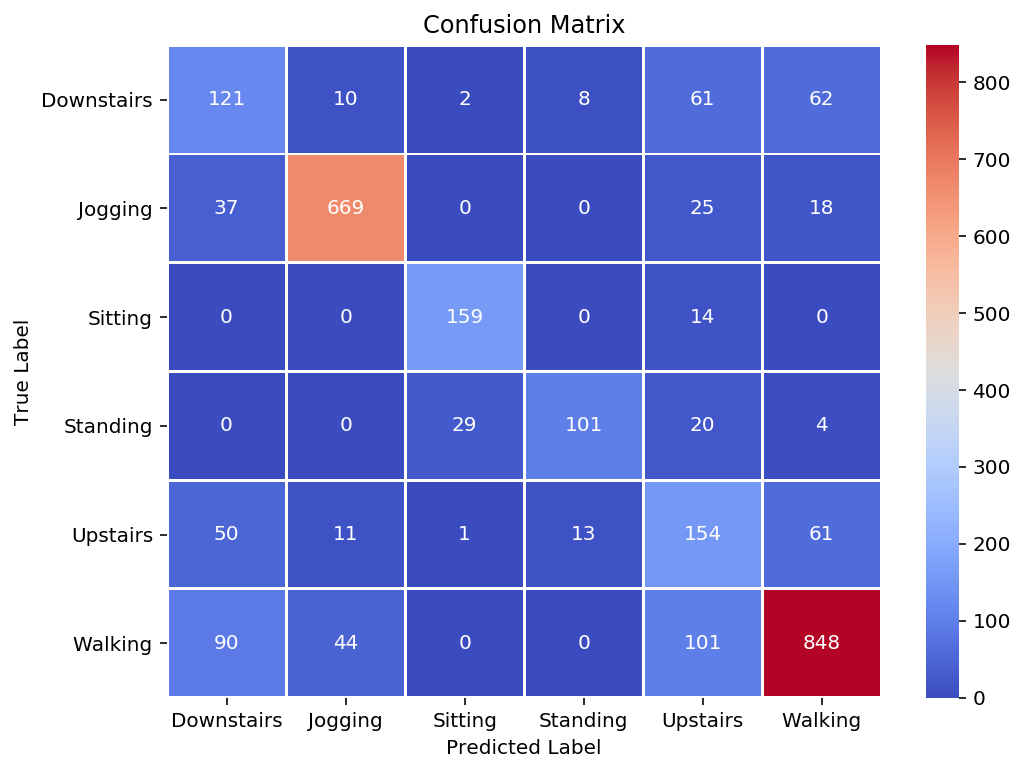

              precision    recall  f1-score   support

           0       0.41      0.46      0.43       264
           1       0.91      0.89      0.90       749
           2       0.83      0.92      0.87       173
           3       0.83      0.66      0.73       154
           4       0.41      0.53      0.46       290
           5       0.85      0.78      0.82      1083

    accuracy                           0.76      2713
   macro avg       0.71      0.71      0.70      2713
weighted avg       0.78      0.76      0.76      2713



In [126]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# CNN (Conv1D)

In [107]:
model_m = Sequential()
model_m.add(Conv1D(64, 2, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 4, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 99, 64)            448       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 64)            16448     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 23, 128)           82048     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)               

In [108]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6201 samples, validate on 1551 samples
Epoch 1/30
6201/6201 [==============================] - 7s 1ms/step - loss: 0.5995 - accuracy: 0.7815 - val_loss: 0.7518 - val_accuracy: 0.7853
Epoch 2/30
 200/6201 [..............................] - ETA: 5s - loss: 0.2942 - accuracy: 0.8950

/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/Keras-2.3.1-py3.7.egg/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


6201/6201 [==============================] - 6s 952us/step - loss: 0.2829 - accuracy: 0.8942 - val_loss: 0.8293 - val_accuracy: 0.7756
Epoch 3/30
6201/6201 [==============================] - 6s 998us/step - loss: 0.1962 - accuracy: 0.9310 - val_loss: 0.9190 - val_accuracy: 0.7685
Epoch 4/30
6201/6201 [==============================] - 6s 1ms/step - loss: 0.1383 - accuracy: 0.9534 - val_loss: 1.0550 - val_accuracy: 0.7292
Epoch 5/30
6201/6201 [==============================] - 6s 945us/step - loss: 0.1065 - accuracy: 0.9663 - val_loss: 0.9663 - val_accuracy: 0.7750
Epoch 6/30
6201/6201 [==============================] - 6s 965us/step - loss: 0.1010 - accuracy: 0.9673 - val_loss: 0.9511 - val_accuracy: 0.7827
Epoch 7/30
6201/6201 [==============================] - 6s 961us/step - loss: 0.0755 - accuracy: 0.9760 - val_loss: 1.1710 - val_accuracy: 0.7763
Epoch 8/30
6201/6201 [==============================] - 6s 1ms/step - loss: 0.0727 - accuracy: 0.9771 - val_loss: 0.9432 - val_accuracy: 

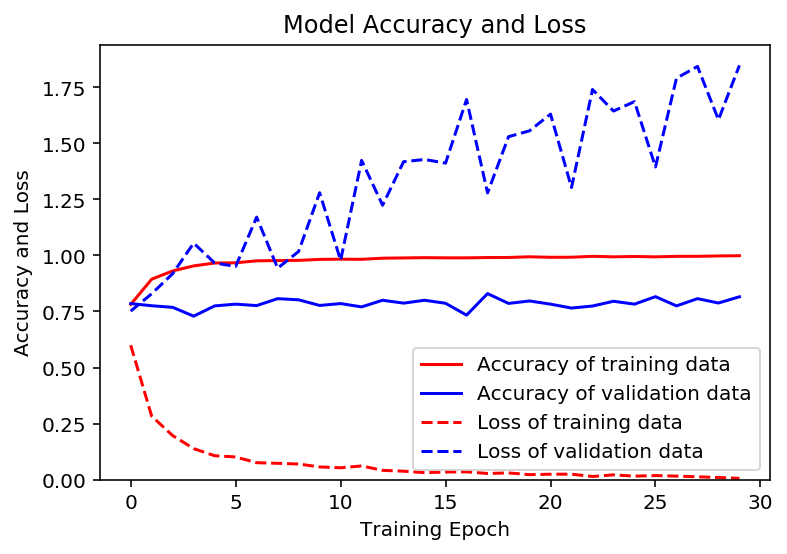

In [116]:
show_4_graphs(history)

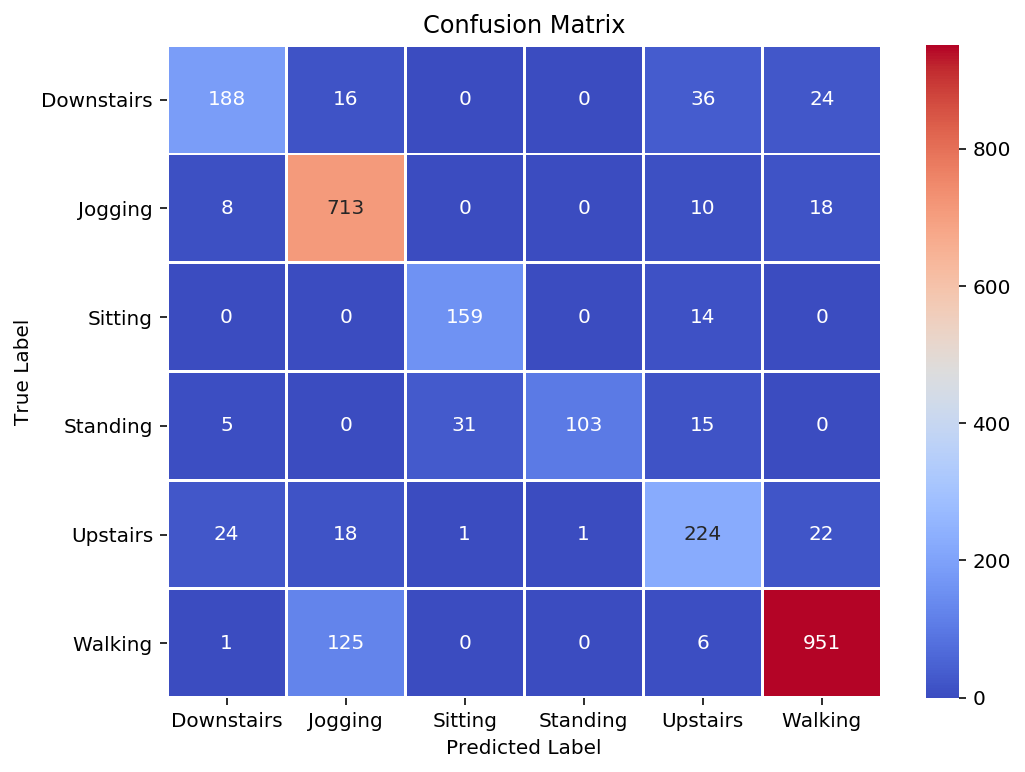

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       264
           1       0.82      0.95      0.88       749
           2       0.83      0.92      0.87       173
           3       0.99      0.67      0.80       154
           4       0.73      0.77      0.75       290
           5       0.94      0.88      0.91      1083

    accuracy                           0.86      2713
   macro avg       0.86      0.82      0.83      2713
weighted avg       0.87      0.86      0.86      2713



In [117]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# RNN

In [0]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

In [0]:
history = model.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6280 samples, validate on 1571 samples
Epoch 1/30
6280/6280 [==============================] - 122s 19ms/step - loss: 0.7831 - acc: 0.7272 - val_loss: 0.4611 - val_acc: 0.8294
Epoch 2/30
6280/6280 [==============================] - 121s 19ms/step - loss: 0.4058 - acc: 0.8537 - val_loss: 0.2733 - val_acc: 0.9077
Epoch 3/30
6280/6280 [==============================] - 121s 19ms/step - loss: 0.2176 - acc: 0.9272 - val_loss: 0.1322 - val_acc: 0.9586
Epoch 4/30
6280/6280 [==============================] - 123s 20ms/step - loss: 0.1499 - acc: 0.9540 - val_loss: 0.1134 - val_acc: 0.9599
Epoch 5/30
4820/6280 [======================>.......] - ETA: 25s - loss: 0.1015 - acc: 0.9705

In [0]:
show_4_graphs(history)

In [0]:
y_pred = model.predict(X_test)
show_results(y_test, y_pred)